## NOTE:
#### 1. ALL THE ANALYSIS PERFORMED BY USING 100K REVIEWS

### Steps to build co-occurence matrix:(Overview)
1. pick top features based on their IDF values and create corpus of top features.
2. create a matrix of shape = (len(corpus), len(corpus))and initialize it with zeros .
3. now select a review and tokenize it.
4. now loop over all the columns and rows of matrix created in step-2 and update it for a review.
5. updation of a matrix:
    
        a.) pick two words from corpus say word1 and word2:
            [a.1] if word1 and word2 are equal and present in a review add zero to this cell.
            [a.2] if word1!=word2 and present in a review , consider word1 as base word and find how much time word2 
                  occur in forward and backward window of base word=word1, and add count(word2) to this cell.

## Load reqired libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
import pickle
import seaborn as sns 
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import multiprocessing as mp
from scipy.sparse import csr_matrix,find
from sklearn.cluster import KMeans
from os import path
import os
import requests
from PIL import Image
from wordcloud import WordCloud
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

## Load required data:

In [3]:
#Functions to save objects for later use and retireve it
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".pkl","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".pkl","rb"))
    return temp

X=openfromfile('X')
X_tfidf=openfromfile('X_tfidf')
tf_idf_vect=openfromfile('tf_idf_vect')
#corpus=openfromfile('corpus')
#coo_all=openfromfile('coo_all')
#df=openfromfile('df')

## Truncated-SVD

### Function for constructing Co-Occurence matrix:

In [4]:
def coo_mat(list_sent_word,corpus,window_len):
    '''CO-OCCURENCE MATRIX CONSTRUCTION FOR GIVEN CORPUS AND WINDOW SIZE GIVEN'''
    coo=np.zeros((len(corpus),len(corpus)))
    i=j=0
    for k in tqdm(range(len(list_sent_word))):
        j=i=0
        for word1 in corpus:
            if word1 in list_sent_word[k]:
                j=0
                for word2 in corpus:
                    count=0
                    if word1!=word2 and word2 in list_sent_word[k]:
                        #FIND THE INDEX OF BASE WORD FROM WHICH WE CALCULATE WINDOW SIZE
                        base_index=[ind for ind,w in enumerate(list_sent_word[k]) if word1==w]
                        for index in base_index:
                            #LIST TO STORE WORDS IN LEFT AND RIGHT SIDE OF BASE WORD WITHIN WINDOW DISTANCE
                            list_word_window=[]
                            if index+1<len(list_sent_word[k]):
                                list_word_window.extend(list_sent_word[k][max(index-window_len,0) : index] +\
                                                        list_sent_word[k][index+1 : index + window_len+1])
                            elif index==len(list_sent_word[k]):
                                list_word_window.extend(list_sent_word[k][index-window_len: index])
                            #NO. OF TIME A WORD IN COLUMN OCCURS IN LEF AND RIGHT WINDOW OF BASE WORD
                            count += list_word_window.count(word2)
                        coo[i][j]+=count
                    #IF BOTH WORDS ARE SAME THEN WE ADD 0 TO THAT CELL
                    else:
                        coo[i][j]+=0
                    j+=1
                #i+=1
            #IF WORD FROM SENTENCE IS NOT IN ROW OF CO-OCCURENCE MATRIX THEN WE ADD 0 TO THAT ROW  
            else:
                coo[i][:]+=0
                #i+=1
            i+=1
    return coo


### Function to draw co-occurence matrix using heatmap:

In [5]:
def visualizeCooMat(coo_mat,corpus,dim=10):
    corpus_row=corpus[:dim]
    coo_mat_df=pd.DataFrame(coo_mat[:dim,:dim],columns=corpus_row,index=corpus_row)
    plt.figure(1,figsize=(18,12))
    sns.set(font_scale=1.2)
    cmat=sns.heatmap(coo_mat_df,annot=True,cmap='RdBu',cbar=False)
    cmat.set_yticklabels(corpus_row,rotation=0)
    plt.title('Part of Co-occurence matrix of dimension(%d * %d)'%(dim,dim),size=20)
    plt.show()

### Function for applying TSVD nd find the optimal no. of feature which can explained max variance:

In [6]:
def OptimalComponents_Mat(co_occ_mat, opt_component, transformed_mat=False):
    '''FUNCTION TO FIND OPTIMA NO. OF COMPONENTS BASED ON ELBOW CURVE'''
    t_svd = TruncatedSVD(n_components=opt_component)
    t_svd_data = t_svd.fit_transform(co_occ_mat)
    #IF TRANSFORMED_MAT =FALSE DRAW ELBOW CURVE ONLY
    if transformed_mat==False:
        cum_var_explained = np.cumsum(t_svd.explained_variance_ratio_)
        plt.figure(1, figsize=(10, 6))
        plt.clf()
        plt.plot(cum_var_explained, linewidth=2)
        plt.axis('tight')
        plt.grid(True)
        plt.xlabel('No. of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title("Total-Variance-Explained VS No. of Components")
        plt.show()
    #IF TRANSFORMED_MAT=TRUE RETURNED TRANSFORMED MATRIX
    else:
        return t_svd_data

### Function for finding top important features based on IDF values:

In [7]:
# Code From -> https://buhrmann.github.io/tfidf-analysis.html
def get_top_n_features(X_tfidf, features, top_n):
    '''FUNCTION FOR FINDING TOP FEATURE'''
    column_mean = np.mean(X_tfidf, axis = 0)
    column_mean = np.array(column_mean)[0].tolist()
    topn_ids = np.argsort(column_mean)[::-1][:top_n]
    top_feats = [(features[i], column_mean[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

### Function for K-Means hyperparameter tunning using elbow method :

In [8]:
def clustering_model(data,params):
    '''HYPERPARAM TUNNING AND DRAW ELBOW CURVE'''
    inertia_value=[]
    for k in tqdm(params['clusters']):
        model=KMeans(n_clusters=k,init='k-means++',n_jobs=-1)
        model.fit(data)
        inertia_value.append(model.inertia_)
    plt.figure(1,figsize=(10,6))
    plt.plot(params['clusters'],inertia_value)
    plt.title('ELBOW METHOD (OPTIMAL HYPERPARAM)')
    plt.xlabel('K(No. of clusters): Hyperparam')
    plt.ylabel('Inertia(Sum of intra cluster distance)')
    plt.grid(True)
    plt.show()
        

### Function for labelling each value of a corpus to cluster label :

In [9]:
def corpus_labelling(data,corpus,params):
    '''FUNCTION FOR LABELCORPUS WITH CLUSTER LABEL AND DRAW BAR PLOT OF NO. OF WORDS DISTRIBUTED TO EACH CLUSTER'''
    model=KMeans(n_clusters=params,precompute_distances=True,init='k-means++',n_jobs=-1)
    model.fit(data)
    labels=model.labels_
    
    cluster_label=np.c_[ corpus, labels ]
    cluster_label_df=pd.DataFrame(cluster_label,columns=['word','label'])
    print(cluster_label_df['label'].value_counts())
    list_samples=[]
    g=cluster_label_df.groupby(['label'])
    for key in g.groups:
        list_samples.append(len(g.groups[key]))
    #BAR CHART 
    if len(list_samples)!=0:
        plt.figure(1,figsize=(10,6))
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        plt.title("NO. of Words per cluster")
        # ADD BARS
        plt.bar(range(len(list_samples)), list_samples) #plt.bar(range(params), list_samples)  
        # ADD LABELS
        plt.xticks(range(len(list_samples)))
        plt.xlabel('No. of Cluster')
        plt.ylabel('No. of Words')
        plt.show()
    else:
        print('All points are declared as noisy points ')
    cluster_label_df=cluster_label_df.astype({'label':int})
    return model,cluster_label_df

### Function for wordcloud:

In [24]:
def wordcloud_each_cluster(optimal_cluster,cluster_label_df):
    '''FUNCTION TO PLOT WORDS BELONGS TO A CLUSTER IN A WORDCLOUD'''
    words_cluster={}
    #PROPERTIES OF TITLE
    title_font = {'size':'20', 'color':'black'}
    #DOWNLOAD AND PUT MASKABLE IMAGE TO CWD
    if not os.path.isfile('mask-cloud.png'):
        url='http://www.shapecollage.com/shapes/mask-cloud.png'
        r=requests.get(url)
        with open('mask-cloud.png','wb') as f:
            f.write(r.content)
    #SHAPE WORDCLOUD ACCORDING TO MASKABLE IMAGE
    mask_image_path = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
    mask = np.array(Image.open(path.join(mask_image_path, "mask-cloud.png")))
    stopwords=set([])
    for i in range(optimal_cluster):
        #INITIALIZE WORDCLOUD OBJECT
        wordcloud = WordCloud(max_font_size=120,\
                              stopwords=stopwords,\
                              colormap='winter',\
                              max_words=100,\
                              collocations=False,
                              relative_scaling=1.0,
                              mask=mask,\
                              background_color='white',\
                              contour_width=2,\
                              contour_color='royalblue')
        #PICK WORDS BELONGS TO EACH CLUSTER
        t=''
        for token in list(cluster_label_df.loc[cluster_label_df['label']==i,\
                                               ['word']]['word']):
            t=t+' '+token
        words_cluster[i]=t.strip().split()
        wordcloud.generate(t)
        #FIGURE SIZE ACCORDING TO NO. OF WORDS
        if len(t.split())<=5:
            plt.figure(1,figsize=(5,5))
        elif len(t.split())>=5:
            plt.figure(1,figsize=(14,13))
        plt.title("WORDS BELONGS TO CLUSTER-%d"%i, **title_font )
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    return words_cluster

### Function which accept a word as input and return similar words to that word:

In [11]:
def similarWords(coo_all, corpus, word, words_in_cluster):
    '''FUNCTION FOR CALCULATING SIMILARITY BETWEEN WORDS AND RETURN SIMILAR WORDS FROM CLUSTER'''
    #DICTIONARY TO STORE WORDS AND ITS SIMILARITY WITH OTHER WIORDS BELONGS TO PARTICULAR CLUSTER
    similar_words={}
    for key in words_in_cluster.keys():
        if word in words_in_cluster[key]:
            #FIND THE INDEX OF WORD IN CORPUS 
            word_index=corpus.index(word)
            #WORD VECTOR OF A WORD GIVEN
            given_word_vector=coo_all[word_index]
            break
            
    for w in words_in_cluster[key]:
        #FIND INDEX OF WORD IN CORPUS
        index=corpus.index(w)
        #COSINE SIMILARITY OF A WORD WITH OTHER WORDS IN THAT CLUSTER
        similar_words[w]=float(cosine_similarity(coo_all[index].reshape(1, -1),given_word_vector.reshape(1, -1)).ravel())
        similarity_df=pd.DataFrame(similar_words,index=[word]).round(3)
    return similarity_df


## Applying TruncateSVD :

### [1.1] Taking top features from TFIDF

In [12]:
no_of_feat=2000
df=get_top_n_features(X_tfidf,tf_idf_vect.get_feature_names(),no_of_feat)
print(df.head(5))
df.shape

  feature     tfidf
0     not  0.044046
1    like  0.026099
2   great  0.025042
3    good  0.025020
4  coffee  0.024549


(2000, 2)

### [1.2] Calulation of Co-occurrence matrix

#### [1.2.1]prepare input for creating C-occurence matrix:

In [13]:
#WINDOW LENGTH
window_len=5
#CORPUS/WORDS FOR WHICH WE HAVE TO CREATE CO-OCCURENCE MATRIX
corpus=list(df['feature'].values)
print('no. of words in a corpus:',len(corpus))
#LIST OF LIST OF WORDS IN A SENTENCE FOR ALL REVIEWS 
list_sent_word=[]
for sent in X:
    list_sent_word.append(sent.split())

no. of words in a corpus: 2000


#### [1.2.2] Create co-occurence matrix:

In [14]:
pool = mp.Pool(mp.cpu_count())
# Step 2: `pool.apply` the `howmany_within_range()`
%time coo_all = pool.apply(coo_mat, args=(list_sent_word,corpus,window_len))
# Step 3: Don't forget to close
pool.close()
#SAVE CO-OCCURENCE MATRIX TO PICKLE FILES
savetofile(coo_all,'coo_all')
#CONVERT CO-OCCURENCE MATRIX TO SPARSE CO-OCCURENCE MATRIX
coo_matrix=csr_matrix(coo_all)  

100%|██████████| 87773/87773 [2:39:38<00:00,  9.16it/s]   


CPU times: user 34.5 s, sys: 20.7 s, total: 55.2 s
Wall time: 2h 39min 41s


#### [1.2.3] Visualization of co-occurence matrix:

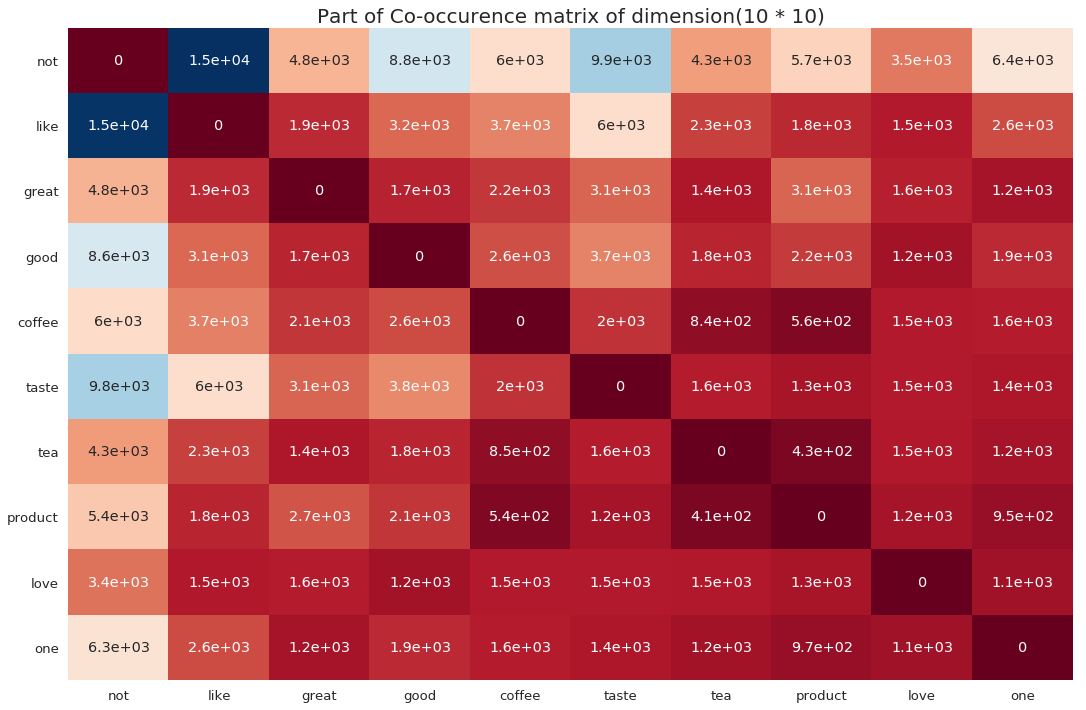

In [29]:
visualizeCooMat(coo_all,corpus,dim=10)

### [1.3] Finding optimal value for number of components (n) to be retained

#### [1.3.1] find optimal no. of component and draw elbow curve:

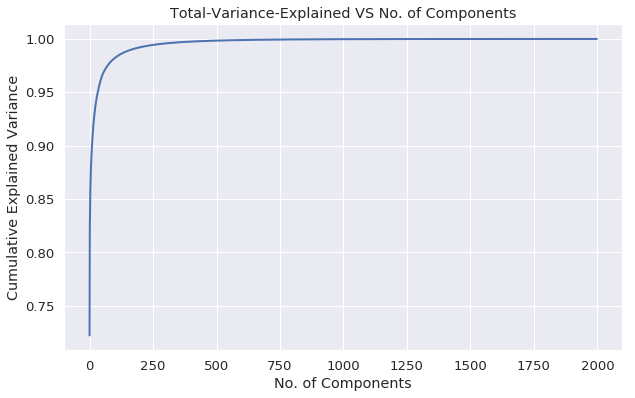

In [16]:
opt_component=coo_all.shape[1]-1
OptimalComponents_Mat(coo_all, opt_component, transformed_mat=False)

### Observation:
1. from the above plot we observe that 98% of the variance is eplained by the 250 features. So we select 250 as optimal no. of features.

#### [1.3.2] Retrained with optimal components:

In [17]:
optimal_components=250
transformed_coo_mat = OptimalComponents_Mat(coo_all,optimal_components,transformed_mat=True)
print(transformed_coo_mat.shape)


(2000, 250)


### [1.4] Applying k-means clustering

In [18]:
params={'clusters':range(2,50,2)}

#### [1.4.1]Hyperparam Tunning using Elbow Method:

100%|██████████| 24/24 [00:00<00:00, 42.81it/s]


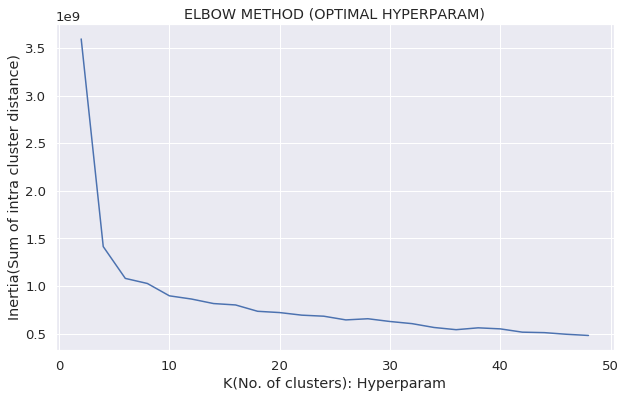

In [19]:
clustering_model(transformed_coo_mat,params)

### Observation:
1. from the above plot we observe that after k=6, inertia reduces gradually so we choose k=6 as our knee point 

#### [1.4.2] corpus labelling and distribution of words per cluster:

0    1732
4     224
1      32
5      10
2       1
3       1
Name: label, dtype: int64


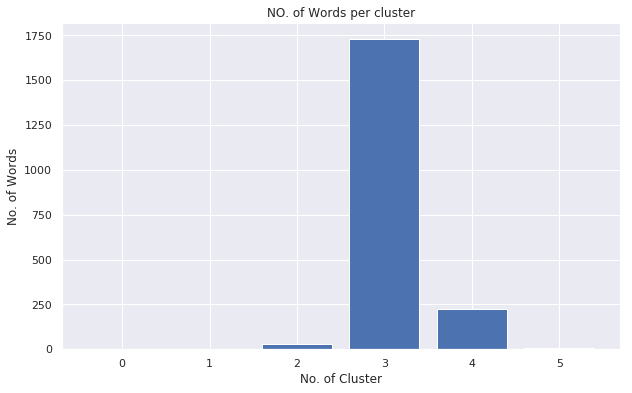

In [20]:
optimal_clusters=6
model,cluster_label_df=corpus_labelling(transformed_coo_mat,corpus,optimal_clusters)

### [1.5] Wordclouds of clusters obtained in the above section

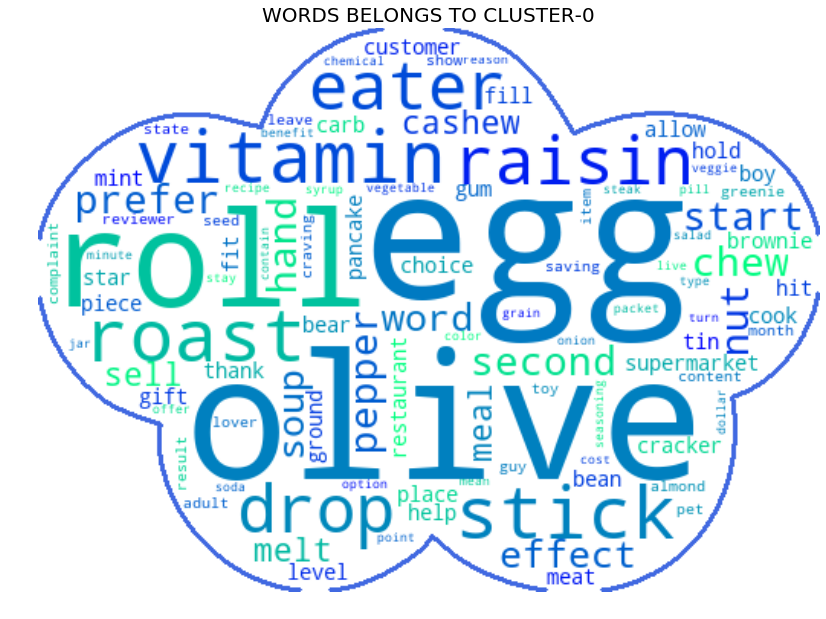

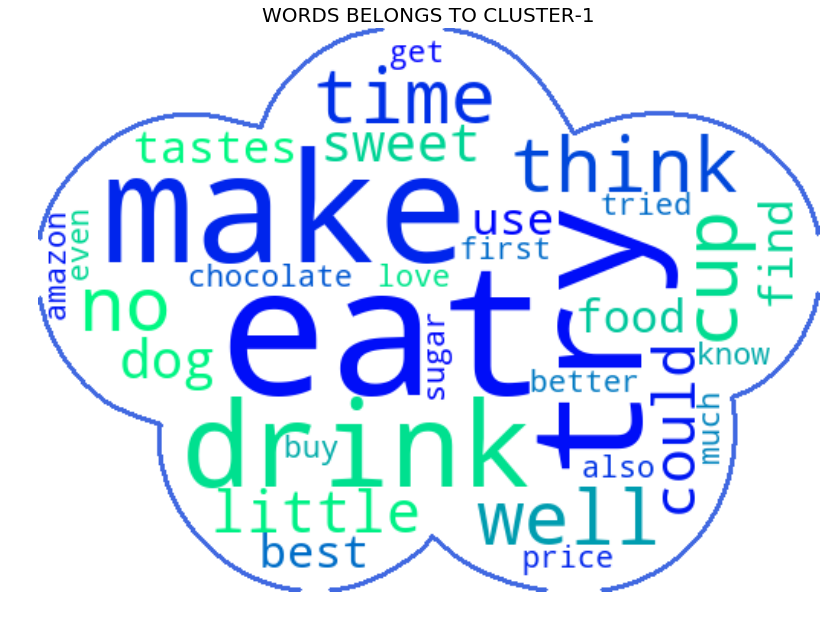

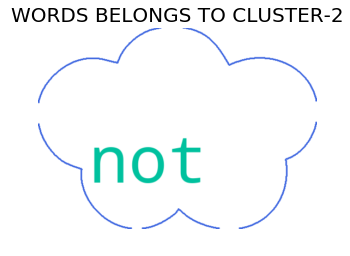

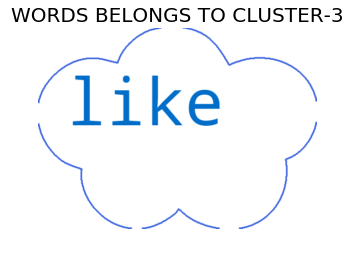

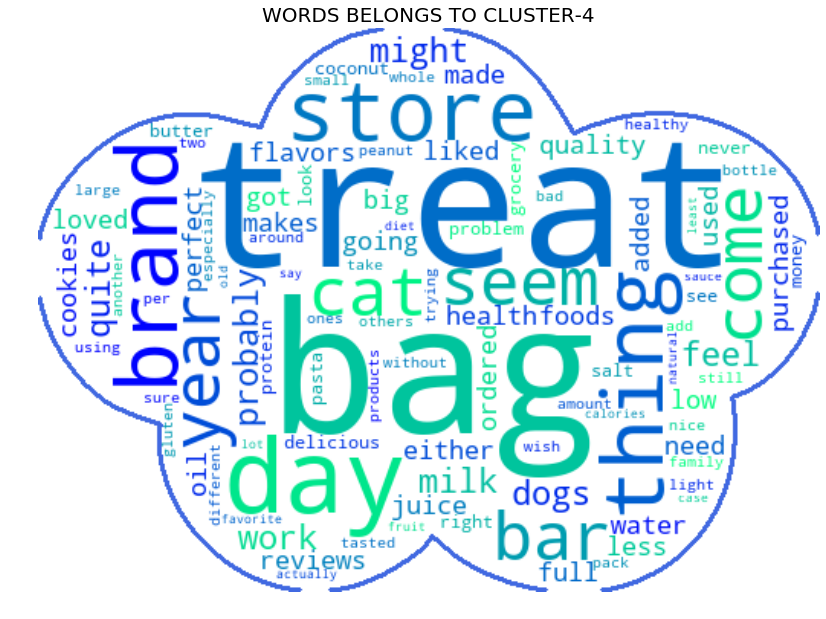

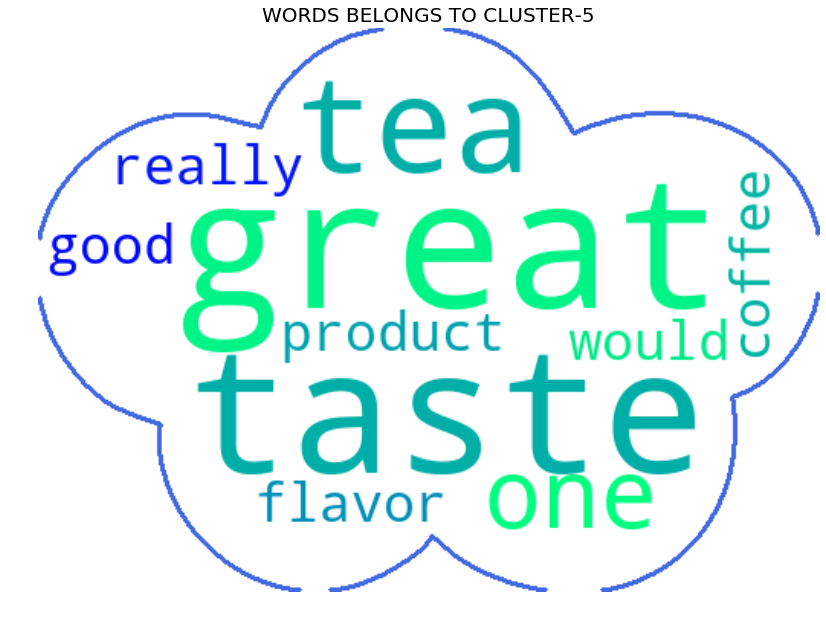

In [27]:
words_cluster=wordcloud_each_cluster(optimal_clusters,cluster_label_df)

### Observation:
1. From the above wordcloud we observe that :
    
    a. cluster-0 contains eatable words like cashew, egg, raisin and olive etc.

### [1.6] Function that returns most similar words for a given word.

In [32]:
word=input('Input word to find similar words to that:')#'great'
similarity_df=similarWords(transformed_coo_mat, corpus, word, words_cluster)
similarity_df

Input word to find similar words to that:eat


,also,amazon,best,better,buy,chocolate,could,cup,dog,drink,...,price,sugar,sweet,tastes,think,time,tried,try,use,well
eat,0.873,0.701,0.707,0.803,0.877,0.738,0.889,0.58,0.783,0.783,...,0.696,0.766,0.841,0.685,0.931,0.829,0.833,0.86,0.858,0.877


### Observation:
1. from the above analysis we oserve that words in a cluster have high similarity with each other.

# [6] Conclusions

1. TSVD is used for dimensionality reduction by discarding features which represent least amount of information.
2. Applying TSVD on Co-Occurence matrix decomposes the co-occurence matrix into 3- matrices:
        a. left singular matrix
        b. right singular matrix
        c. diagonal matrix having singular values in diagonal
3. The product of left singular matrix and diagonal matrix of singular values shows word vector representation.
4. C-Occurence matrix preserves the semantic relationship between words. 

#### The optimal values for: 
        1. number of components = 250 
        2. number of clusters = 6


REFERENCE LINKS:
1. https://stackoverflow.com/questions/41661801/python-calculate-the-co-occurrence-matrix
2. https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
3. https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285
4. https://stackoverflow.com/questions/37331708/nltk-find-occurrences-of-a-word-within-5-words-left-right-of-context-words-in